# Time Series Prediction with Stateful LSTM

### Abstract
This Jupyter notebook demonstrates the use of Google Tensorflow to perform a time series prediction task.

Here, a recurrent neural network, more specifically a stateful Long Short Term Memory (LSTM) is used.

<b>Tested on Google TensorFlow V1.0 (https://github.com/tensorflow/tensorflow)</b>

#### References:
1. François Chollet's Keras example using <i>stateful LSTM</i> (https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py)

#### Dependencies
1. Python 3.5.2
2. TensorFlow (GPU) 1.0.1
3. Keras 2.0.2 (refer to https://keras.io/backend/ to configure backend)

##### Overview:
1. Import Libraries 
2. Setup Environment
3. Configure Parameters
4. Prepare Data
5. Configure LSTM Network
6. Train
7. Evaluate
8. Visualize Prediction

### Step 1: Import Libraries

In [1]:
# Generic Libraries
import os, sys, warnings
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# ML Libraries
import keras
import tensorflow as tf

# Keras Libraries
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


### Step 2: Setup Environment

In [2]:
# enable inline plotting of graphs within Jupyter notebook
%matplotlib inline

# ensure reproducible output
np.random.seed(7)

# suppress non-essential warnings
os.environ['TF_CPP_MI_LOG_LEVEL'] = '3' # tensorflow
#warnings.filterwarnings("ignore") # numpy

# confirm versions of key libraries
print("python:{}, \nkeras:{}, \ntensorflow:{}".format(sys.version, keras.__version__, tf.__version__))

python:3.5.2 |Anaconda 4.3.1 (64-bit)| (default, Jul  5 2016, 11:41:13) [MSC v.1900 64 bit (AMD64)], 
keras:2.0.2, 
tensorflow:1.0.1


### Step 3: Configure Parameters

In [3]:
# Hyper-parameters
timesteps    = 1   # using stateful LSTM
batch_size   = 1   # using stateful LSTM
epochs       = 100
#lookahead    = 1    # number of elements ahead to predict
num_features = 1    # number of features
data_size    = 21600

### Step 4: Prepare Data

1. Load Data
2. Normalize OR Standardize Data - state difference
3. Prepare Train/Test Samples

In [4]:
def load_dataset(filename, header, usecols, skipfooter, delimiter=None, delim_whitespace=False):
    df = pd.read_csv(
                        filename, 
                        header=header, 
                        usecols=usecols, 
                        skipfooter=skipfooter, 
                        engine='python', 
                        delimiter=delimiter, 
                        delim_whitespace=delim_whitespace
                    )
    print(df.describe())
    plt.figure(figsize=(15,4))
    plt.title('Selected Data')
    plt.plot(df[0:data_size])
    plt.show()
    dataset = df.values
    dataset = dataset.astype('float32')    
    return dataset

                  1
count  21600.000000
mean       4.871742
std        0.175890
min        3.955000
25%        4.810000
50%        4.885000
75%        4.960000
max        6.200000


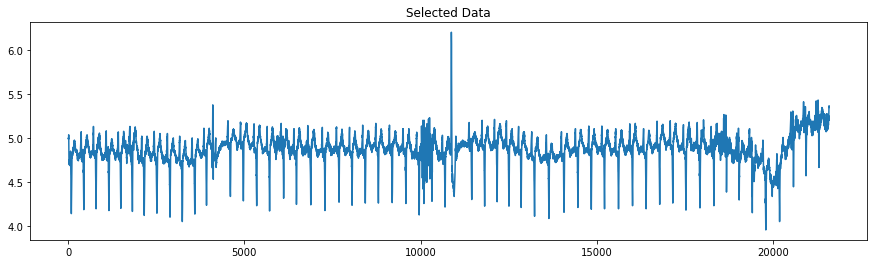

In [5]:
# load the dataset
# https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line    
#dataset = load_dataset(filename='data/international-airline-passengers.csv', header='infer', usecols=[1], skipfooter=2)
#dataset = load_dataset(filename='data/sp500.csv', header=None, usecols=[0], skipfooter=0)
#dataset = load_dataset(filename='data/household_power_consumption_cleansed.txt', header='infer', usecols=[2], skipfooter=0, delimiter=';')

dataset = load_dataset(filename='data/mitdbx_mitdbx_108.txt', header=None, usecols=[1], skipfooter=0, delim_whitespace=True)

In [6]:
# normalize using MinMax to obtain a range of (0,1)
def normalize_dataset(dataset):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler, scaler.fit_transform(dataset)

In [7]:
scaler, dataset_norm = normalize_dataset(dataset)
print('Dataset normalized.')

Dataset normalized.


In [8]:
# convert an array of values into train and test data
def split_train_test_data(dataset, look_back, split):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        dataX.append(dataset[i:(i + look_back), 0])
        dataY.append(dataset[i + look_back, 0])
    
    dataX = np.array(dataX)
    dataY = np.array(dataY)

    # split into train and test sets
    train_size = int(len(dataset) * split)
    test_size = len(dataset) - train_size
    trainX, testX = dataX[0:train_size,:], dataX[train_size:len(dataX),:]
    trainY, testY = dataY[0:train_size], dataY[train_size:len(dataY)]

    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
    
    # add last entry from dataset to be able to predict unknown testY
    temp = dataset[len(dataset) - timesteps:len(dataset), 0]
    temp = np.reshape(temp, (1, temp.shape[0]))
    temp = np.reshape(temp, (temp.shape[0], temp.shape[1], 1))
    testX = np.append(testX, temp, 0)
    
    return trainX, trainY, testX, testY

In [9]:
trainX, trainY, testX, testY = split_train_test_data(dataset_norm[0:data_size,:], look_back=timesteps, split=0.67)
print('Data split into train and test set.')

Data split into train and test set.


### Step 5: Configure LSTM Network

In [10]:
def build_model():
    model = Sequential()
    model.add(LSTM(4, 
                   batch_input_shape=(batch_size, timesteps, num_features), 
                   stateful=True, 
                   return_sequences=True))
    model.add(LSTM(4, # There is no need for an batch_input_shape in the second layer
                   return_sequences=False,
                   stateful=True)) 
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [11]:
print('Model Summary')

model = build_model()
model.summary()

Model Summary
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 4)                 96        
_________________________________________________________________
lstm_2 (LSTM)                (1, 4)                    144       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    5         
Total params: 245.0
Trainable params: 245
Non-trainable params: 0.0
_________________________________________________________________


### Step 6: Train

In [12]:
print('Start training...')
loss_history = []
for i in range(epochs):
    print('Epoch', i+1, '/', epochs)

    # Note that the last state for sample i in a batch will
    # be used as initial state for sample i in the next batch.
    # Thus we are simultaneously training on batch_size series with
    # lower resolution than the original series contained in cos.
    # Each of these series are offset by one step and can be
    # extracted with cos[i::batch_size].
    
    history = model.fit(
                    trainX, 
                    trainY, 
                    epochs=1, 
                    batch_size=batch_size, 
                    verbose=2, 
                    shuffle=False
                )
    loss_history.append(history.history['loss'])
    model.reset_states() # required for stateful LSTMs

Start training...
Epoch 1 / 100
Epoch 1/1
128s - loss: 0.0033
Epoch 2 / 100
Epoch 1/1
126s - loss: 0.0030
Epoch 3 / 100
Epoch 1/1
135s - loss: 8.4047e-04
Epoch 4 / 100
Epoch 1/1
431s - loss: 4.8742e-04
Epoch 5 / 100
Epoch 1/1
127s - loss: 3.4523e-04
Epoch 6 / 100
Epoch 1/1
127s - loss: 2.8309e-04
Epoch 7 / 100
Epoch 1/1
129s - loss: 2.8954e-04
Epoch 8 / 100
Epoch 1/1
129s - loss: 2.2726e-04
Epoch 9 / 100
Epoch 1/1
129s - loss: 2.1263e-04
Epoch 10 / 100
Epoch 1/1
125s - loss: 1.9209e-04
Epoch 11 / 100
Epoch 1/1
126s - loss: 1.8306e-04
Epoch 12 / 100
Epoch 1/1
987s - loss: 1.8103e-04
Epoch 13 / 100
Epoch 1/1
126s - loss: 1.5153e-04
Epoch 14 / 100
Epoch 1/1
126s - loss: 1.4585e-04
Epoch 15 / 100
Epoch 1/1
126s - loss: 1.3979e-04
Epoch 16 / 100
Epoch 1/1
125s - loss: 1.3420e-04
Epoch 17 / 100
Epoch 1/1
125s - loss: 1.3563e-04
Epoch 18 / 100
Epoch 1/1
127s - loss: 1.4890e-04
Epoch 19 / 100
Epoch 1/1
126s - loss: 1.4597e-04
Epoch 20 / 100
Epoch 1/1
125s - loss: 1.4436e-04
Epoch 21 / 100
Epoc

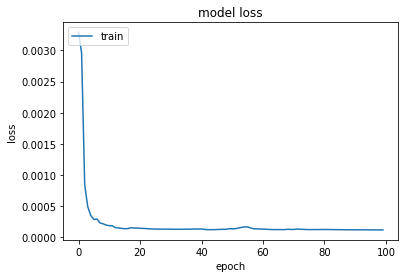

In [13]:
# summarize history for loss
plt.plot(loss_history)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

### Step 7: Evaluate

In [14]:
# make predictions on train and test

# train data
trainPredict = model.predict(trainX, batch_size=batch_size)

# reset states
model.reset_states()

# test data
testPredict = model.predict(testX, batch_size=batch_size)

print('Prediction performed against train and test data.')

Prediction performed against train and test data.


In [15]:
# invert predictions to revert to initial scale
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])

testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [16]:
# print next predicted value
print('Prediction of the next value:', round(testPredict[len(testPredict) - 1, 0],3))

Prediction of the next value: 5.214


In [17]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.05 RMSE


### Step 8: Visualize

Visualize results


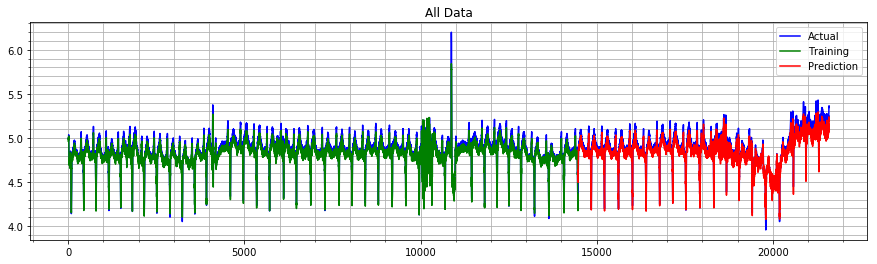

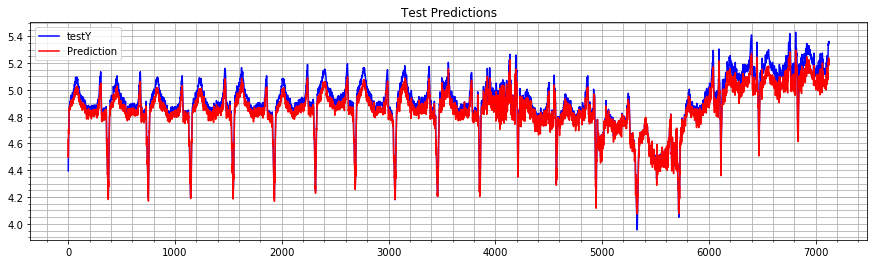

In [18]:
print('Visualize results')

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset_norm[0:data_size,:]) # create array with same shape as dataset
trainPredictPlot[:, :] = np.nan # fill with nan
trainPredictPlot[timesteps:len(trainPredict) + timesteps, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset_norm[0:data_size,:]) # create array with same shape as dataset
testPredictPlot[:, :] = np.nan # fill with nan
test = ['nan']
test = np.reshape(test, (len(test), 1))
testPredictPlot = np.append(testPredictPlot, test, 0)
testPredictPlot[len(trainPredict) + timesteps:len(dataset_norm[0:data_size,:]) + 1, :] = testPredict

# plot baseline and predictions
plt.figure(figsize=(15,4))
plt.title('All Data')
plt.plot(scaler.inverse_transform(dataset_norm[0:data_size,:]), color='b', label='Actual')
plt.plot(trainPredictPlot, color='g', label='Training')
plt.plot(testPredictPlot, color='r', label='Prediction')
plt.grid(True)
plt.grid(b=True, which='minor', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()

# zoom in on the test predictions
plt.figure(figsize=(15,4))
plt.title('Test Predictions')

testYPlot = np.reshape(testY, [testY.shape[1], 1]) # testY is [0, n] need to change shape to [n, 0] to plot it
testYPlot = testYPlot[testYPlot.shape[0] - len(testPredict) + 1:testYPlot.shape[0]] # +1, because testY has one less value than testPredict
plt.plot(testYPlot, color='b', label='testY')
testPredictPlot = testPredict[len(testPredict) - len(testPredict):len(testPredict), :]
plt.plot(testPredictPlot, color='r', label='Prediction')
plt.grid(True)
plt.grid(b=True, which='minor', axis='both')
plt.minorticks_on()
plt.legend()
plt.show()